In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import join

from clip_grounding.utils.paths import REPO_PATH
sys.path.append(join(REPO_PATH, "CLIP_explainability/Transformer-MM-Explainability/"))

In [86]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import CLIP.clip as clip
import cv2
from PIL import Image
from glob import glob
from natsort import natsorted

from clip_grounding.utils.paths import REPO_PATH
from clip_grounding.utils.io import load_json
from clip_grounding.utils.visualize import set_latex_fonts, show_grid_of_images
from clip_grounding.utils.image import pad_to_square
from clip_grounding.datasets.png_utils import show_images_and_caption
from clip_grounding.datasets.png import (
    PNG,
    visualize_item,
    overlay_segmask_on_image,
    overlay_relevance_map_on_image,
    get_text_colors,
)
from clip_grounding.evaluation.clip_on_png import (
    process_entry_image_to_text,
    process_entry_text_to_image,
    interpret_and_generate,
)

## Load dataset

In [4]:
dataset = PNG(dataset_root=join(REPO_PATH, "data/panoptic_narrative_grounding"), split="val2017")

### Load and visualize a sample

In [70]:
def visualize_entry_text_to_image(entry):
    test_img, test_texts, orig_image = process_entry_text_to_image(entry, unimodal=False)
    outputs = interpret_and_generate(model, test_img, test_texts, orig_image, return_outputs=True, show=False)
    relevance_map = outputs[0]["image_relevance"]
    
    image_with_mask = overlay_segmask_on_image(entry["image"], entry["image_mask"])
    image_with_mask = pad_to_square(image_with_mask)
    
    image_with_relevance_map = overlay_relevance_map_on_image(entry["image"], relevance_map)
    image_with_relevance_map = pad_to_square(image_with_relevance_map)
    
    text_colors = get_text_colors(entry["text"], entry["text_mask"])
    
    show_images_and_caption(
        [image_with_mask, image_with_relevance_map],
        entry["text"], text_colors, figsize=(18, 5),
    )

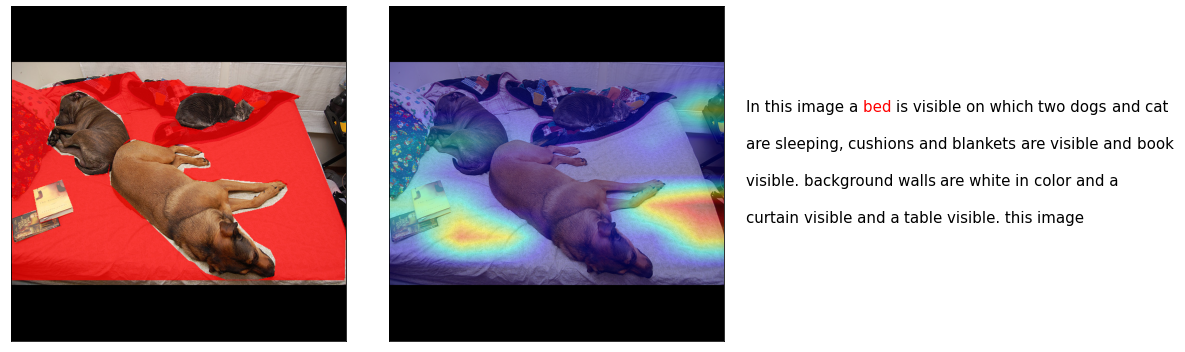

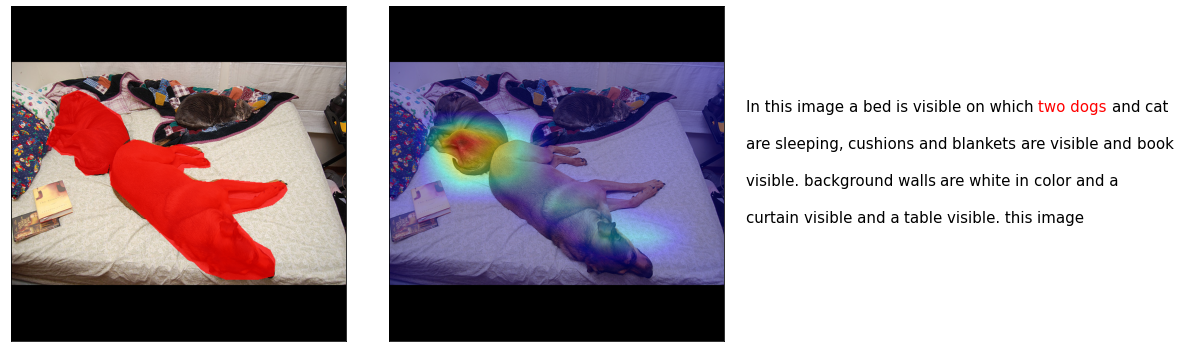

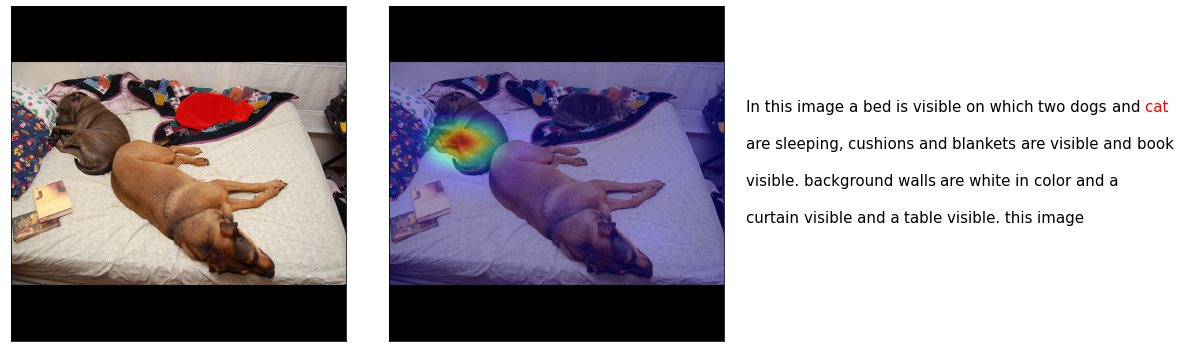

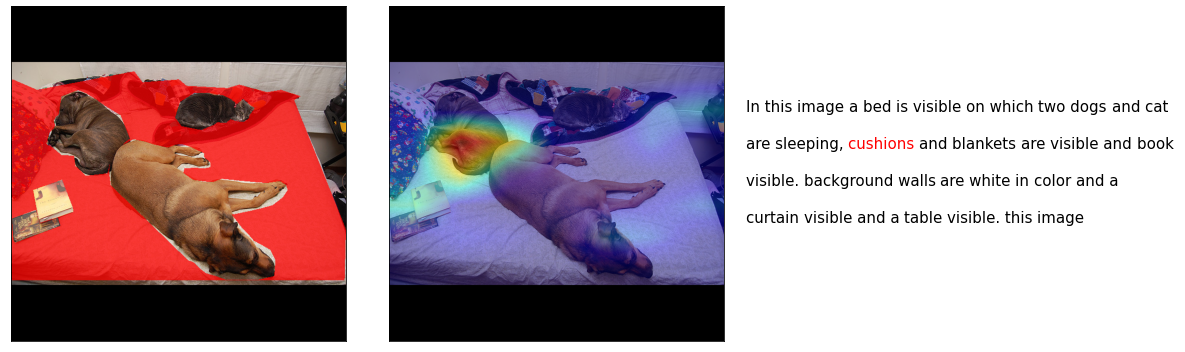

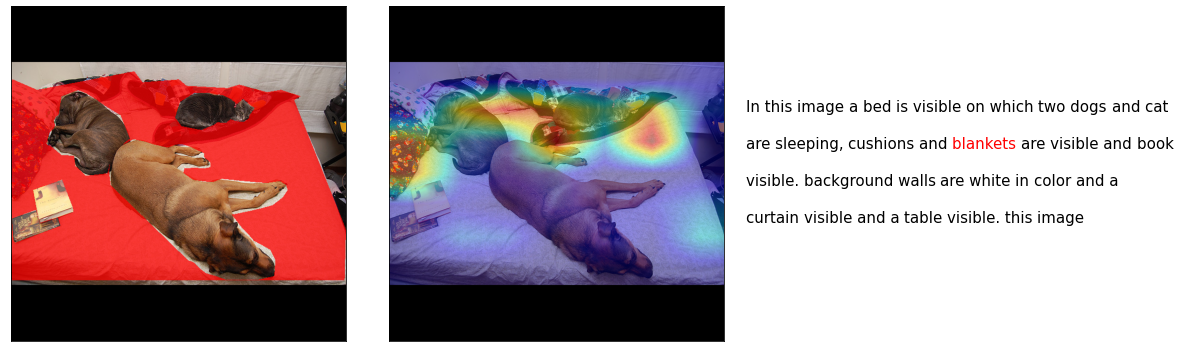

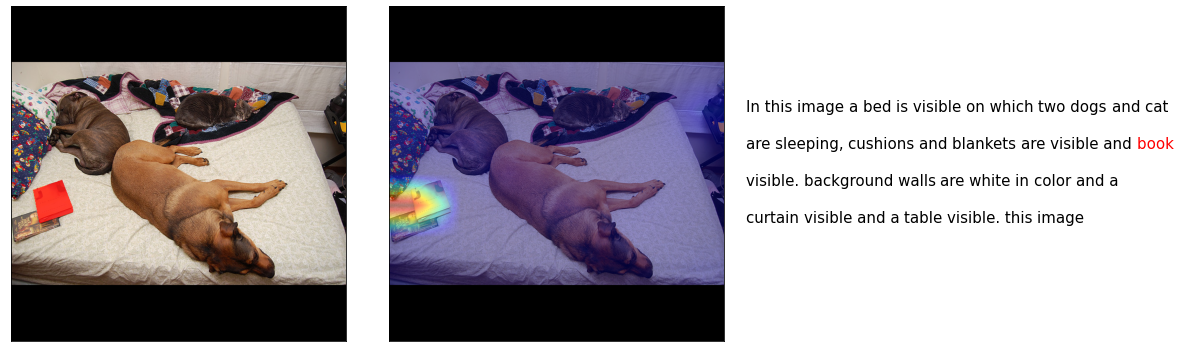

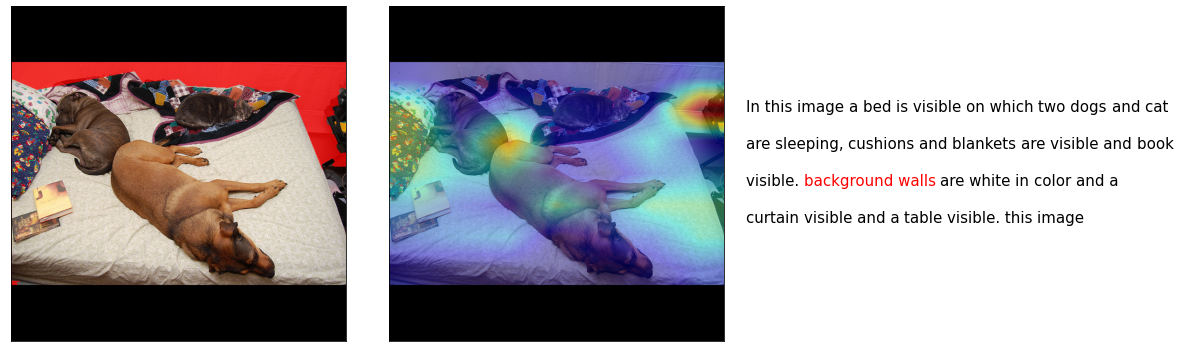

In [75]:
idx = 100
instance = dataset[idx]

instance_dir = join(REPO_PATH, "figures", f"instance-{idx}")
os.makedirs(instance_dir)

for i, entry in enumerate(instance):
    del entry["full_caption"]

    visualize_entry_text_to_image(entry)
    
    save_path = instance_dir
    plt.savefig(join(instance_dir, f"viz-{i}.png"), bbox_inches="tight")

In [80]:
def create_and_save_gif(filenames, save_path, **kwargs):
    import imageio
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(save_path, images, **kwargs)

In [87]:
filenames = natsorted(glob(join(instance_dir, "viz-*.png")))
save_path = join(instance_dir, "together.gif")

create_and_save_gif(filenames, save_path, duration=3)

## Debugging code for a single entry

In [71]:
idx = 100
instance = dataset[idx]
entry = instance[1]
del entry["full_caption"]

In [58]:
entry.keys()

dict_keys(['image', 'text', 'image_mask', 'text_mask'])

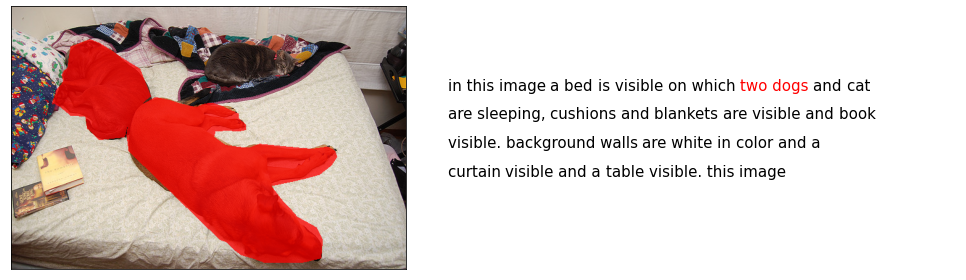

In [59]:
visualize_item(**entry)

### Visualize everything together

In [60]:
# load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [61]:
test_img, test_texts, orig_image = process_entry_text_to_image(entry, unimodal=False)
outputs = interpret_and_generate(model, test_img, test_texts, orig_image, return_outputs=True, show=False)
relevance_map = outputs[0]["image_relevance"]

In [62]:
image_with_mask = overlay_segmask_on_image(entry["image"], entry["image_mask"])
image_with_mask = pad_to_square(image_with_mask)

In [63]:
image_with_mask.size

(640, 640)

In [64]:
relevance_map.min(), relevance_map.max(), relevance_map.shape

(0.0, 1.0, (224, 224))

In [65]:
image_with_relevance_map = overlay_relevance_map_on_image(entry["image"], relevance_map)
image_with_relevance_map = pad_to_square(image_with_relevance_map)

In [66]:
text_colors = get_text_colors(entry["text"], entry["text_mask"])

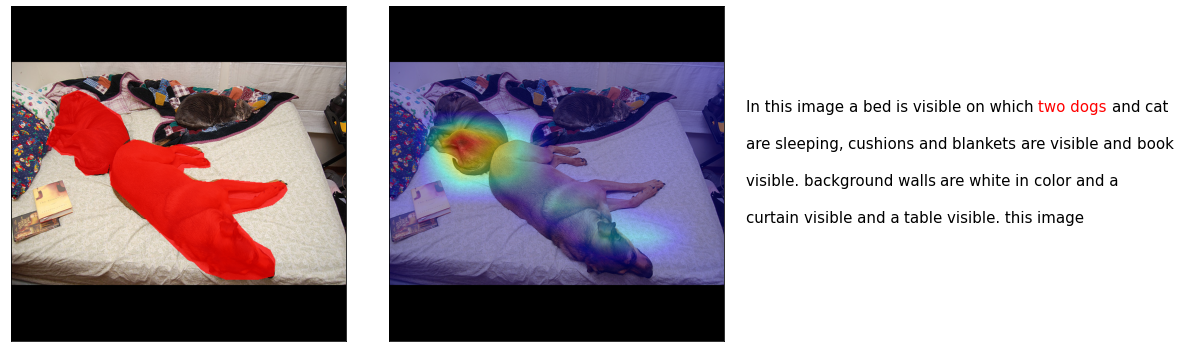

In [69]:
show_images_and_caption([image_with_mask, image_with_relevance_map], entry["text"], text_colors, figsize=(18, 5))
plt.savefig("../figures/viz-1.pdf", bbox_inches="tight")